In [1]:
import os
import sys

os.chdir("..")
print("Now CWD is:", os.getcwd())

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from utils.mnist_reader import load_mnist
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)

# change back
os.chdir("models")
print("Now CWD is:", os.getcwd())

Now CWD is: /Users/zackeryhe/Desktop/sophomore/cs178/178-final
Now CWD is: /Users/zackeryhe/Desktop/sophomore/cs178/178-final/models


In [7]:
class SVCModel:
    def __init__(self, kernel: str = 'linear', probability: bool = True, **kwargs):
        self.model = svm.SVC(kernel=kernel, probability=probability, **kwargs)
        self.class_names = ['T-shirt','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']
    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def plot_learning_curve(self, X, y, cv=5, scoring='accuracy',
                            train_sizes=np.linspace(0.1, 1.0, 5)):
        train_sizes, train_scores, val_scores = learning_curve(
            self.model, X, y,
            cv=cv,
            scoring=scoring,
            train_sizes=train_sizes,
            n_jobs=-1,
            shuffle=True,
            random_state=1234
        )
        train_mean = np.mean(train_scores, axis=1)
        val_mean   = np.mean(val_scores, axis=1)

        plt.figure()
        plt.plot(train_sizes, train_mean, 'o-', label="Train score")
        plt.plot(train_sizes, val_mean,   'o-', label="CV score")
        plt.xlabel("Training examples")
        plt.ylabel(scoring.capitalize())
        plt.title("Learning Curve")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, X, y, normalize=None):
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)

        plt.figure()
        plt.imshow(cm, interpolation='nearest')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.xticks(np.arange(10), self.class_names, rotation=45)
        plt.yticks(np.arange(10), self.class_names)
        # annotate counts
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i, j], ha='center', va='center')
        plt.tight_layout()
        plt.show()

    def plot_precision_recall_curve(self, X, y, average='micro'):
        if not hasattr(self.model, "predict_proba"):
            raise AttributeError("Model has no `predict_proba`—cannot get scores.")

        y_bin = label_binarize(y, classes=self.model.classes_)
        y_score = self.model.predict_proba(X)

        precision, recall, _ = precision_recall_curve(
            y_bin.ravel(), y_score.ravel()
        )
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        plt.figure()
        disp.plot()
        plt.title(f"Precision–Recall Curve ({average}-average)")
        plt.show()

In [5]:
class SGDModel:
    def __init__(
        self,
        loss: str = 'hinge',
        max_iter: int = 1000,
        tol: float = 1e-3,
        random_state: int = 1234,
        **kwargs
    ):
        # Configure SGDClassifier for (approximate) hinge-loss optimization
        self.model = SGDClassifier(
            loss=loss,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state,
            **kwargs
        )

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def plot_learning_curve(
        self,
        X,
        y,
        cv: int = 5,
        scoring: str = 'accuracy',
        train_sizes: np.ndarray = np.linspace(0.1, 1.0, 5)
    ):
        train_sizes, train_scores, val_scores = learning_curve(
            self.model,
            X,
            y,
            cv=cv,
            scoring=scoring,
            train_sizes=train_sizes,
            n_jobs=-1,
            shuffle=True,
            random_state=1234
        )
        train_mean = np.mean(train_scores, axis=1)
        val_mean   = np.mean(val_scores, axis=1)

        plt.figure()
        plt.plot(train_sizes, train_mean, 'o-', label="Train score")
        plt.plot(train_sizes, val_mean,   'o-', label="CV score")
        plt.xlabel("Training examples")
        plt.ylabel(scoring.capitalize())
        plt.title("Learning Curve")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(
        self,
        X,
        y,
        normalize=None,
        cmap=plt.cm.Blues
    ):
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred, normalize=normalize)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=self.model.classes_
        )
        plt.figure(figsize=(8, 8))
        disp.plot(cmap=cmap,
                  values_format='.2f' if normalize else 'd',
                  xticks_rotation=45)
        plt.title(
            "Confusion Matrix" +
            (f" (normalized)" if normalize else "")
        )
        plt.show()

    def plot_precision_recall_curve(
        self,
        X,
        y,
        average: str = 'micro'
    ):
        # binarize labels for multiclass
        y_bin = label_binarize(y, classes=self.model.classes_)
        # decision scores for ranking
        y_scores = self.model.decision_function(X)

        precision, recall, _ = precision_recall_curve(
            y_bin.ravel(),
            y_scores.ravel()
        )
        disp = PrecisionRecallDisplay(
            precision=precision,
            recall=recall
        )
        plt.figure()
        disp.plot()
        plt.title(f"Precision–Recall Curve ({average}-average)")
        plt.show()

    def plot_loss_by_epoch(
        self,
        X,
        y,
        max_epochs: int = 20
    ):
        # initialize a fresh SGD for iterative training
        clf = SGDClassifier(
            loss=self.model.loss,
            max_iter=1,
            tol=None,
            warm_start=True,
            random_state=self.model.random_state
        )
        classes = np.unique(y)
        errors = []
        for epoch in range(1, max_epochs + 1):
            clf.partial_fit(X, y, classes=classes)
            errors.append(1 - clf.score(X, y))

        plt.figure()
        plt.plot(range(1, max_epochs + 1), errors, 'o-')
        plt.xlabel("Epoch")
        plt.ylabel("Training error")
        plt.title("Training Error vs. Epoch")
        plt.grid(True)
        plt.show()

In [10]:
X_train, y_train = load_mnist('../data/fashion', kind='train')
X_test,  y_test  = load_mnist('../data/fashion', kind='t10k')

results = []
frac = 0.01
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=frac,
    stratify=y_train,
    random_state=1234
)

# model = SVCModel(kernel='linear', probability=True)
# SVC doesn't have the loss thing we are looking for
model = SVCModel()
model.fit(X_sub, y_sub)

In [27]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test  accuracy:", model.score(X_test,  y_test))

Train accuracy: 0.7517833333333334
Test  accuracy: 0.7426


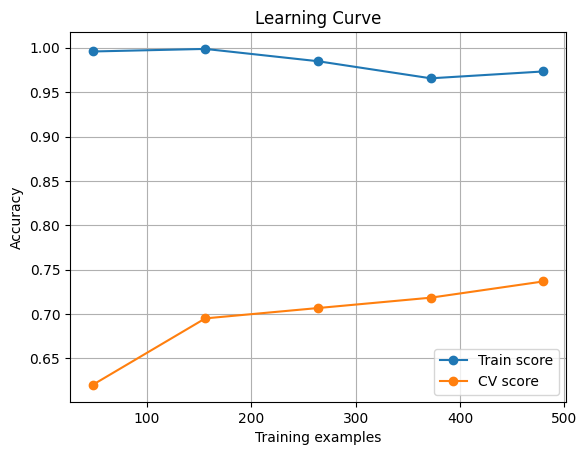

In [28]:
model.plot_learning_curve(X_sub, y_sub)

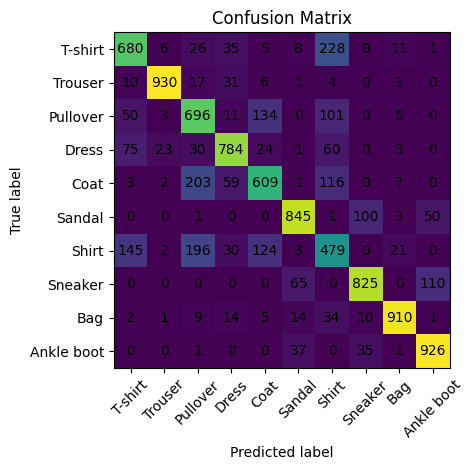

In [11]:
model.plot_confusion_matrix(X_test, y_test, normalize='true')

<Figure size 640x480 with 0 Axes>

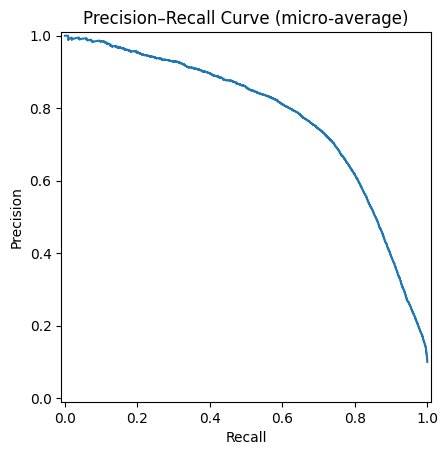

In [30]:
model.plot_precision_recall_curve(X_test, y_test)

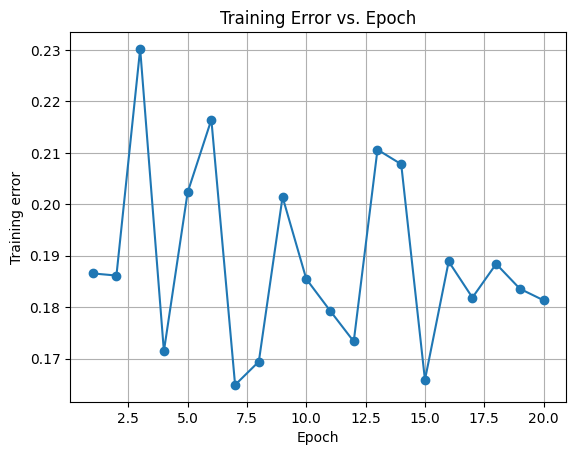

In [31]:
model.plot_loss_by_epoch(X_train, y_train, max_epochs=20) # only for SGDModel